<a href="https://colab.research.google.com/github/jayantc14/Yelp_Data_Analysis/blob/main/Bidirectional_LSTM_Word2vec_senticlassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/yelp_dataset/final_data_yelp2.csv")
df.head()


,Unnamed: 0,Unnamed: 0.1,business_id,city,state_x,user_id,review_stars,useful_x,text,date,useful_y,fans,Smogscore,review_word_count,Polarity,Analysis_TextBlob,Vader Sentiment,Vader Analysis,fips,cases,deaths,label
0,0,0,uexKxrLmPO5iaXRT9TvWqQ,Portland,OR,1eSNY9Csb9ajO7__ci2vTA,3.0,0.0,Yes I am a fan of the food Ive tried more ...,2019-01-01,0.0,0.0,13.4,251.0,0.050208,Positive,0.7723,Positive,0.0,0.0,0.0,1.0
1,1,1,b4PgITSqSWoPhyJ-Mjko7Q,Portland,OR,KYCpm1B9eIIgbPatCIcVkg,4.0,0.0,Im not a bubble tea connoisseur but Ive had it...,2019-01-01,328.0,6.0,0.0,46.0,0.263889,Positive,0.8519,Positive,0.0,0.0,0.0,1.0
2,2,2,2EJpVjliJ6Ceijbz9HSpeQ,Portland,OR,f1lLNjrLk4ETU2t_N7fHbA,5.0,1.0,Fantastic authentic Italian food the pinsa ha...,2019-01-01,8.0,0.0,12.2,74.0,0.360000,Positive,0.9307,Positive,0.0,0.0,0.0,1.0
3,3,3,7m_Tj6xC5CjulQ-6Wucdpw,Portland,OR,uOSQbOnLRlAuWfCSCwQFnA,5.0,0.0,Good food very authentic The owner is pretty f...,2019-01-01,1.0,0.0,6.4,16.0,0.425000,Positive,0.9169,Positive,0.0,0.0,0.0,1.0
4,4,4,DgvT9AiuePR8Z0SKV5BFvw,Portland,OR,bSTMk_GXsPE93COgqUDnMg,4.0,0.0,The service is outstanding and the pasta is go...,2019-01-01,0.0,0.0,8.8,39.0,0.450000,Positive,0.9217,Positive,0.0,0.0,0.0,1.0


In [4]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'business_id', 'city', 'state_x',
       'user_id', 'review_stars', 'useful_x', 'date', 'useful_y',
       'fans', 'Smogscore', 'review_word_count', 'Polarity',
       'Analysis_TextBlob', 'Vader Sentiment', 'Vader Analysis', 'fips',
       'cases', 'deaths'],axis = 1,inplace = True)

In [5]:
df

,text,label
0,Yes I am a fan of the food Ive tried more ...,1.0
1,Im not a bubble tea connoisseur but Ive had it...,1.0
2,Fantastic authentic Italian food the pinsa ha...,1.0
3,Good food very authentic The owner is pretty f...,1.0
4,The service is outstanding and the pasta is go...,1.0
...,...,...
197944,I have to admit Shin Hakata Ramen was truly im...,1.0
197945,The BEST Rueben in Boston Hands down And I hav...,1.0
197946,Mike Pattys is such a cool neighborhood gem I...,1.0
197947,Store is a little hard to find since it is hid...,1.0


In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [7]:


nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
y = df["label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)



In [9]:
import gensim

In [10]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method 
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [11]:
len(w2v_model.wv.vocab)



120213

In [12]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [13]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[481, 416, 1, 27, 83, 545, 1130, 234, 41, 1261]

In [14]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break        

food -> 1
good -> 2
place -> 3
great -> 4
service -> 5
like -> 6
one -> 7
time -> 8
back -> 9
get -> 10


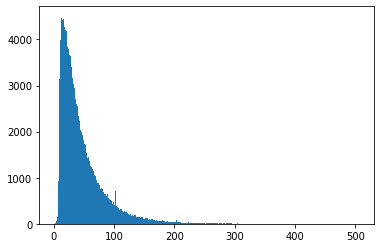

In [15]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 200 words.
# Lets keep each news small and truncate all news to 200 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()




In [16]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])
# Out of 48k news, 44k have less than 700 words

197949

In [17]:
#Lets keep all reviews to 700(or 200), add padding to news with less than 200 words and truncating long ones
maxlen = 700 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [18]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [19]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [20]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [22]:
 from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [23]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])



In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 700, 100)          12021400  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 12,256,153
Trainable params: 234,753
Non-trainable params: 12,021,400
_________________________________________________________________


In [25]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 


In [26]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

Epoch 1/6
3248/3248 [==============================] - 811s 248ms/step - loss: 0.1481 - acc: 0.9373 - val_loss: 0.1226 - val_acc: 0.9491
Epoch 2/6
3248/3248 [==============================] - 801s 247ms/step - loss: 0.1081 - acc: 0.9540 - val_loss: 0.1068 - val_acc: 0.9537
Epoch 3/6
3248/3248 [==============================] - 800s 246ms/step - loss: 0.0903 - acc: 0.9617 - val_loss: 0.1052 - val_acc: 0.9538
Epoch 4/6
3248/3248 [==============================] - 788s 242ms/step - loss: 0.0726 - acc: 0.9695 - val_loss: 0.1093 - val_acc: 0.9539
Epoch 5/6
3248/3248 [==============================] - 784s 241ms/step - loss: 0.0547 - acc: 0.9777 - val_loss: 0.1284 - val_acc: 0.9535
Epoch 6/6
3248/3248 [==============================] - 787s 242ms/step - loss: 0.0389 - acc: 0.9851 - val_loss: 0.1467 - val_acc: 0.9520


In [27]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [28]:
accuracy_score(y_test, y_pred)

0.9531401551891368

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.70      0.75      4888
         1.0       0.97      0.98      0.97     44600

    accuracy                           0.95     49488
   macro avg       0.89      0.84      0.86     49488
weighted avg       0.95      0.95      0.95     49488

